In [1]:
# import code block 

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torchquantum as tq
import time 
 
# import quantum_datasets as qd




## A Matter of Taste challenge :  
### Building a phase identification classifier of the quantum many-body system.

## *Quantum-Train*:   
### Rethinking Hybrid Quantum-Classical Machine Learning in the Model Compression Perspective

The contents of this notebook are sorted in the following manner:  
1. Generate the training data and testing data from the PennyLane quantum dataset. 
2. Construct a Phase identification classifier by Pytorch, pure classically. 
3. Introduce the Quantum-Train (QT) concept, to train the same classical NN by a QNN and Mapping model, with polylog parameter reduction.
4. The QT part of the code is contructed by TorchQuantum, the training and testing result will be shown. 

### Generate the training data and testing data from the PennyLane quantum dataset. 
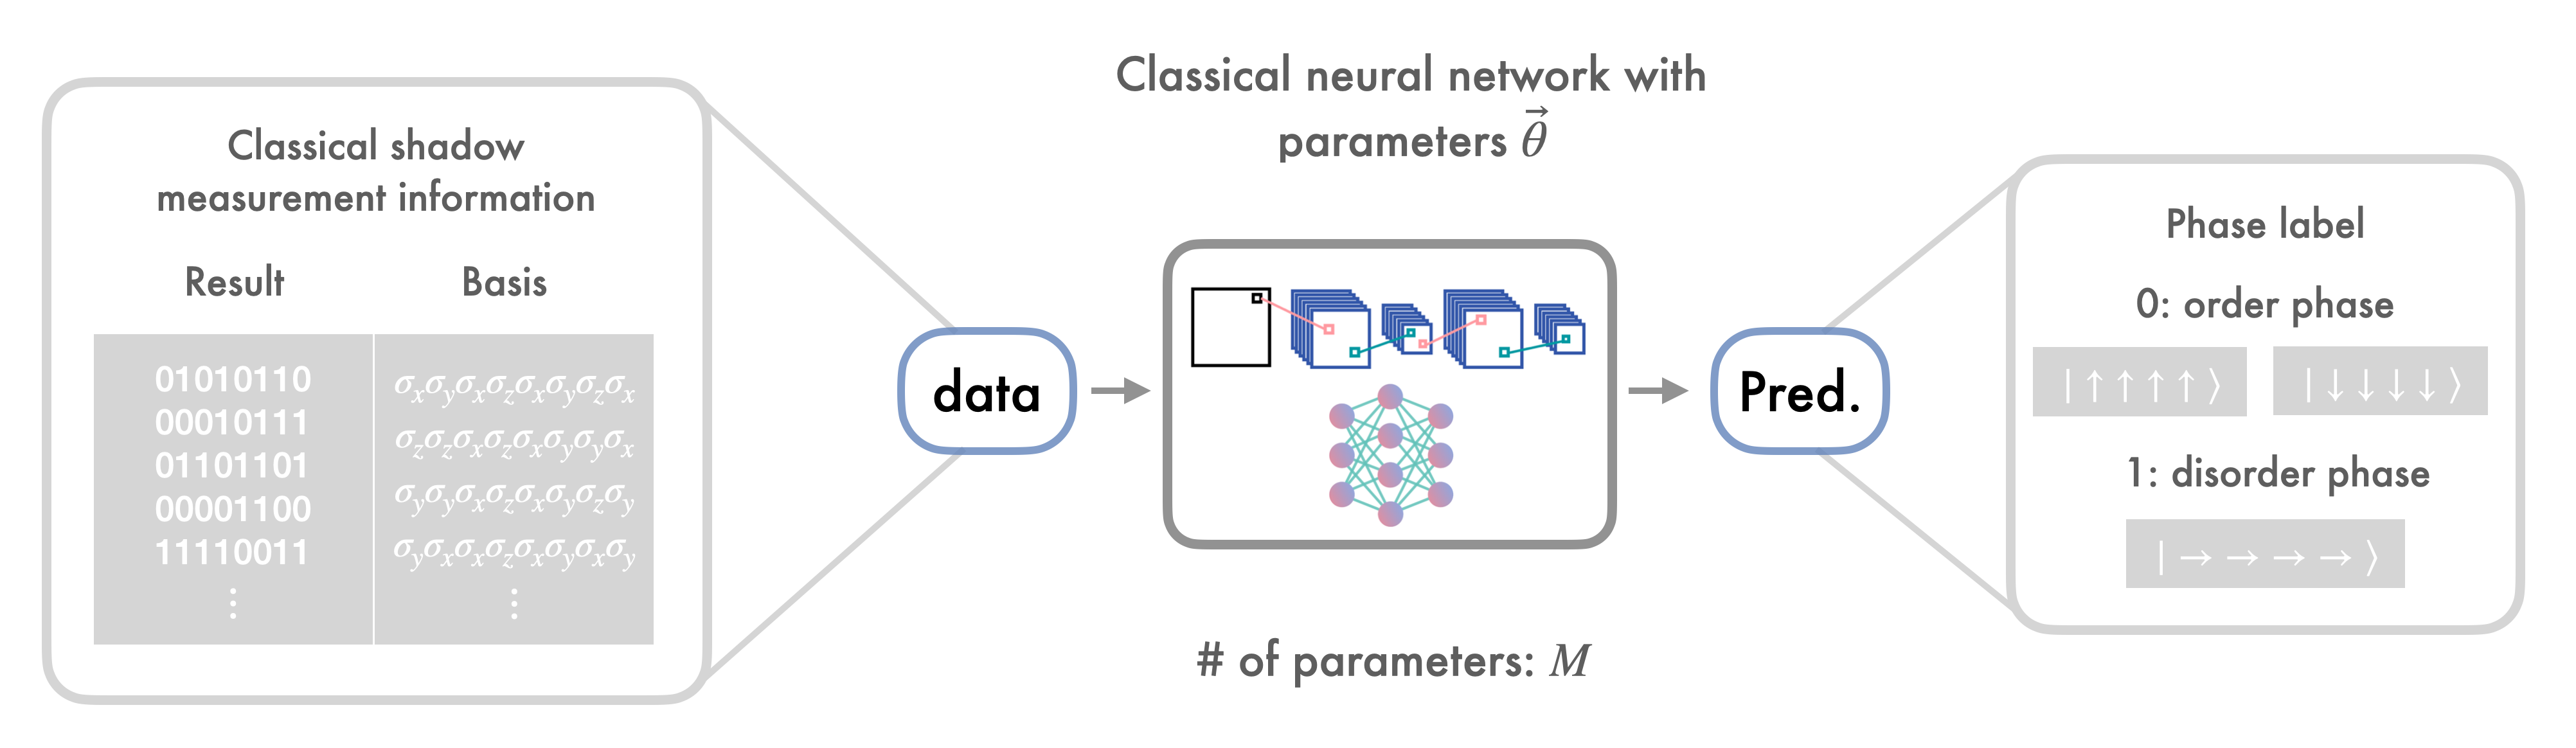

In [2]:
## Load the Transverse-Field Ising Model chain data set for 1x16 layout
Ising_chain_data_set = qml.data.load("qspin", sysname="Ising", periodicity="full", lattice="chain", layout=["1x16"])

In [4]:
## Combine the classical shadow measurement result and the corresponding basis into the single matrix, 
## where 25 samples are picked in each data. 

dataset_shadow_meas_and_basis = [] 
for h_value in range(100):
    for slice_ in range(40):
        sample_per_slice = 25
        dataset_shadow_meas_and_basis.append(
            
            torch.cat(
            (
                # We only train with open periodicity data, therefore we only take Ising_chain_data_set[0]
                torch.tensor(Ising_chain_data_set[0].shadow_meas[h_value][sample_per_slice*slice_:sample_per_slice*(slice_+1)]),
                torch.tensor(Ising_chain_data_set[0].shadow_basis[h_value][sample_per_slice*slice_:sample_per_slice*(slice_+1)]),
                # torch.full((sample_per_slice,), Ising_chain_data_set[0].parameters['h'][h_value]).unsqueeze(1)

            ),
            dim = 1).unsqueeze(0).float()
        )
        
        

In [5]:
dataset_shadow_meas_and_basis[0].shape

torch.Size([1, 25, 32])

In [6]:
## Construct the label data, here we use the phase label as the target of the classifcation task. 

dataset_order_parameter = [] 
for h_value_index in range(100):
    for slice_ in range(40):
        dataset_order_parameter.append(
            #torch.tensor(Ising_chain_data_set[0].parameters['h'][h_value_index]).float()
            torch.tensor((1/8)*Ising_chain_data_set[0].order_params[h_value_index]).float()
        )
        
dataset_phase_label = [] 
for h_value_index in range(100):
    for slice_ in range(40):
        h = Ising_chain_data_set[0].parameters['h'][h_value_index]
        if h < 1:
            dataset_phase_label.append(0)
        elif h >= 1:
            dataset_phase_label.append(1)

In [7]:
## A function to transform the dataset that can be fed into Pytorch


class MatrixDataset(Dataset):
    """Matrix and label dataset."""

    def __init__(self, matrices, labels):
        """
        Args:
            matrices (list of numpy.ndarray or torch.Tensor): List of matrices.
            labels (list of int): List of labels corresponding to each matrix.
        """
        self.matrices = matrices
        self.labels = labels

    def __len__(self):
        return len(self.matrices)

    def __getitem__(self, idx):
        matrix = self.matrices[idx]
        label = self.labels[idx]

        # Convert to torch.Tensor if not already
        if not isinstance(matrix, torch.Tensor):
            matrix = torch.tensor(matrix, dtype=torch.float32)

        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label, dtype=torch.long)

        return matrix, label

In [8]:

# dataset = MatrixDataset(dataset_shadow_meas_and_basis, dataset_order_parameter)
dataset = MatrixDataset(dataset_shadow_meas_and_basis, dataset_phase_label)


## split the data for testing and training 

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # 20% for testing

# Calculate the interval for selecting test indices in the interleaved pattern
# The +1 ensures that we round up, preventing the train set from being too small
interval = int(dataset_size / test_size) + 1

train_indices = []
test_indices = []

for i in range(dataset_size):
    if i % interval == 0:
        test_indices.append(i)
    else:
        train_indices.append(i)

# Adjust the sizes in case of rounding issues
while len(train_indices) > train_size:
    # Move excess from train to test to maintain the size constraint
    train_indices, test_indices = train_indices[:-1], test_indices + [train_indices[-1]]

while len(test_indices) > test_size:
    # Move excess from test to train if necessary
    test_indices, train_indices = test_indices[:-1], train_indices + [test_indices[-1]]


### Construct a pure classical Phase identification classifier by Pytorch. 


In [22]:
batch_size = 20

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device("cuda:0")

### model initialization ###

learning_rate = 0.001
num_epochs = 25


# Define the CNN model (Phase identification classifier)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)  # 1st conv layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer
        self.conv2 = nn.Conv2d(8, 12, kernel_size=5)  # 2nd conv layer
        self.fc1 = nn.Linear(5 * 3 * 12, 200) # These paremeters varies according to the input size (if test with different # of spin,  this need adjustment) 
        self.fc2 = nn.Linear(200, 2)  # Output layer

    def forward(self, x):
        # print(x.size())
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Instantiate the model and loss function
model = CNNModel()
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

Epoch [1/25], Step [100/160], Loss: 0.2615
Epoch [2/25], Step [100/160], Loss: 0.7686
Epoch [3/25], Step [100/160], Loss: 0.1945
Epoch [4/25], Step [100/160], Loss: 0.2959
Epoch [5/25], Step [100/160], Loss: 0.0951
Epoch [6/25], Step [100/160], Loss: 0.1263
Epoch [7/25], Step [100/160], Loss: 0.2453
Epoch [8/25], Step [100/160], Loss: 0.0347
Epoch [9/25], Step [100/160], Loss: 0.0229
Epoch [10/25], Step [100/160], Loss: 0.0837
Epoch [11/25], Step [100/160], Loss: 0.0053
Epoch [12/25], Step [100/160], Loss: 0.0038
Epoch [13/25], Step [100/160], Loss: 0.0900
Epoch [14/25], Step [100/160], Loss: 0.0004
Epoch [15/25], Step [100/160], Loss: 0.0005
Epoch [16/25], Step [100/160], Loss: 0.0002
Epoch [17/25], Step [100/160], Loss: 0.0000
Epoch [18/25], Step [100/160], Loss: 0.0001
Epoch [19/25], Step [100/160], Loss: 0.0001
Epoch [20/25], Step [100/160], Loss: 0.0001
Epoch [21/25], Step [100/160], Loss: 0.0001
Epoch [22/25], Step [100/160], Loss: 0.0002
Epoch [23/25], Step [100/160], Loss: 0.00

In [23]:
# Evaluate the training set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")

# Evaluate the performance on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

Accuracy on the train set: 100.00%
Accuracy on the test set: 89.88%


### Quantum-Train (QT) concept could be summarized into the graph 
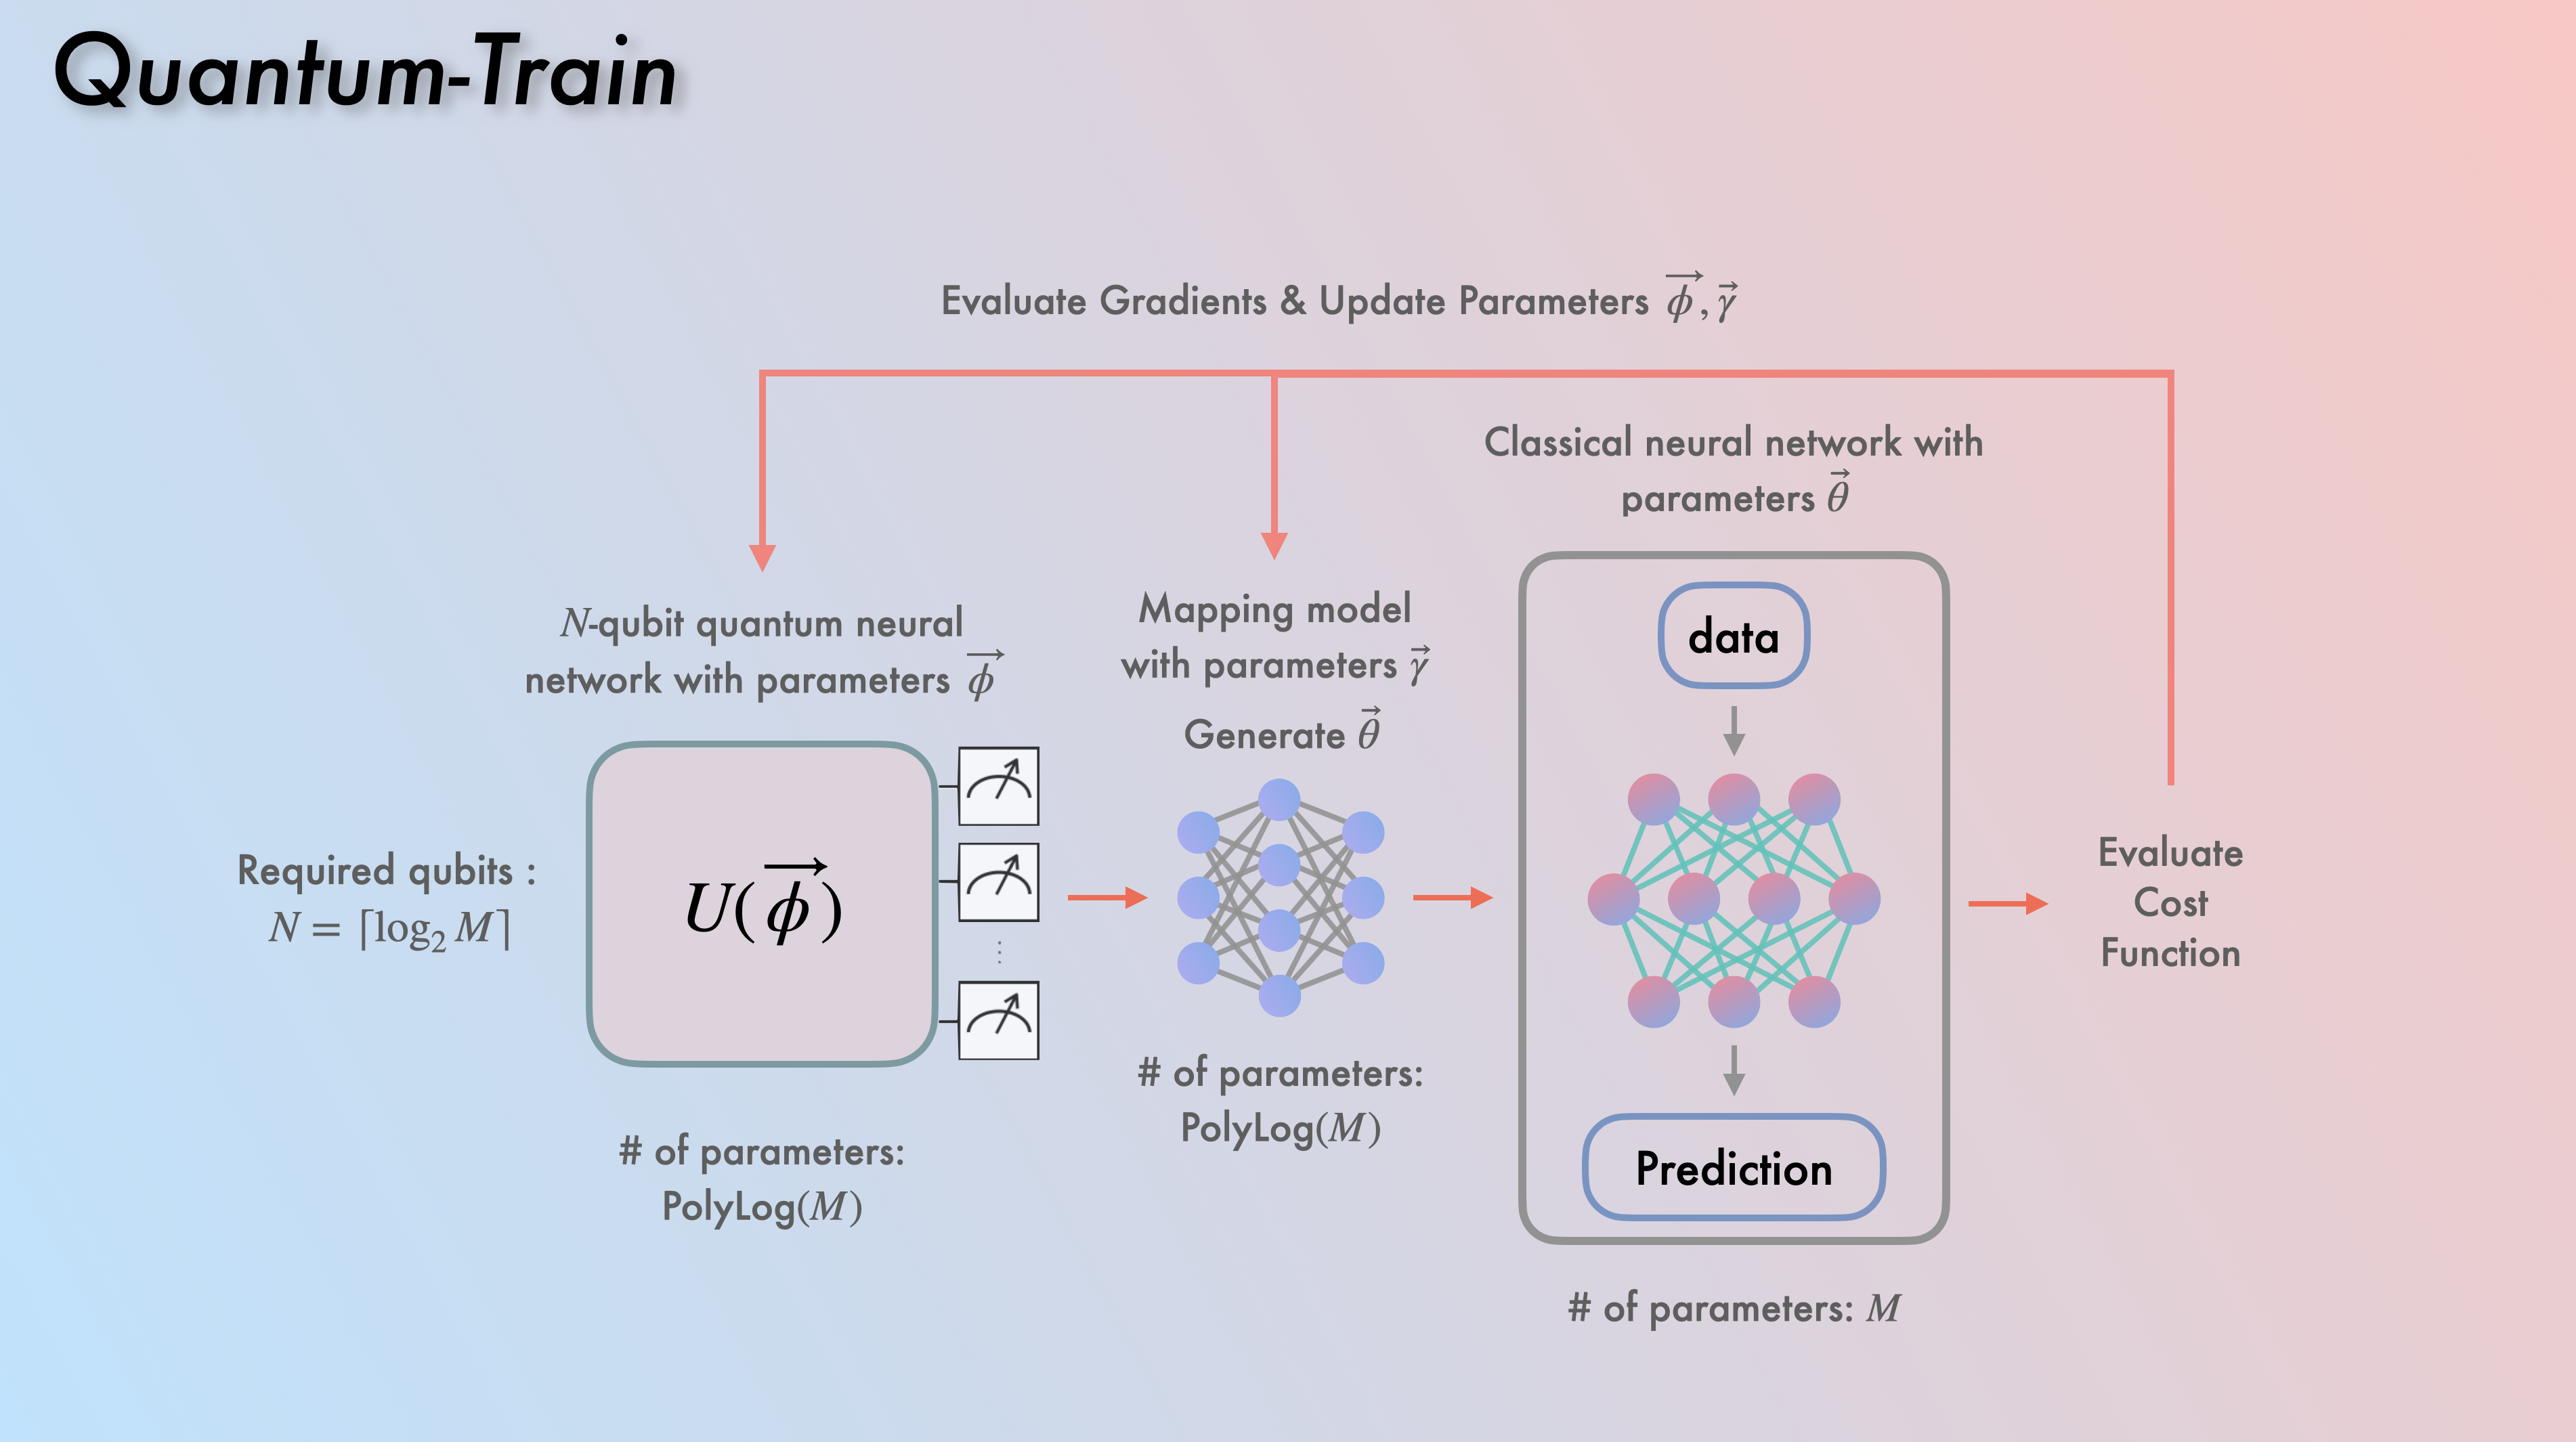

#### First, we estimate how many qubits are required for the above Phase identification classifier

In [11]:
### required qubits estimation ##############
# NN weights

numpy_weights = {}
nw_list = [] 
nw_list_normal = []
for name, param in model.state_dict().items():
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of NN parameters: ", len(nw_list_normal))
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
print("Required qubit number: ", n_qubits)

n_qubit = n_qubits

#############################################

# of NN parameters:  39222
Required qubit number:  16


In [12]:


### Some tool function definitions ###########
def probs_to_weights(probs_):

    new_state_dict = {}
    data_iterator = probs_.view(-1)

    for name, param in CNNModel().state_dict().items():
        shape = param.shape
        num_elements = param.numel()
        chunk = data_iterator[:num_elements].reshape(shape)
        new_state_dict[name] = chunk
        data_iterator = data_iterator[num_elements:]
        
    return new_state_dict

def generate_qubit_states_torch(n_qubit):
    # Create a tensor of shape (2**n_qubit, n_qubit) with all possible combinations of 0 and 1
    all_states = torch.cartesian_prod(*[torch.tensor([-1, 1]) for _ in range(n_qubit)])
    return all_states

#############################################

### Main Learning-wise Hybridization model ##

class LewHybridNN(nn.Module):
    class QLayer(nn.Module):
        def __init__(self, n_blocks):
            super().__init__()
            self.n_wires = int(np.ceil(np.log2(len(nw_list_normal)))),
            self.n_wires = self.n_wires[0]
            self.n_blocks = n_blocks
            self.u3_layers = tq.QuantumModuleList()
            self.cu3_layers = tq.QuantumModuleList()
            # self.measure = tq.MeasureAll(tq.PauliZ)
            for _ in range(self.n_blocks):
                self.u3_layers.append(
                    tq.Op1QAllLayer(
                        op=tq.U3,
                        n_wires=self.n_wires,
                        has_params=True,
                        trainable=True,
                    )
                )
                self.cu3_layers.append(
                    tq.Op2QAllLayer(
                        op=tq.CU3,
                        n_wires=self.n_wires,
                        has_params=True,
                        trainable=True,
                        circular=True,
                    )
                )
                
        def forward(self):
            qdev = tq.QuantumDevice(
                n_wires=self.n_wires, bsz=1, device=next(self.parameters()).device
            )
            easy_scale_coeff = 2**(n_qubit-1)
            gamma = 0.1
            beta  = 0.8
            alpha = 0.3
            for k in range(self.n_blocks):
                self.u3_layers[k](qdev)
                self.cu3_layers[k](qdev)
                
            state_mag = qdev.get_states_1d().abs()[0] 
            state_mag = state_mag[:len(nw_list_normal)]
            x = torch.abs(state_mag) ** 2
            # x = torch.log(x)
            x = x.reshape(len(nw_list_normal),1)
            x = (beta*torch.tanh(gamma*easy_scale_coeff*x))**(alpha) 
            x = x - torch.mean(x)
            x.to(device)
            return x

        
        
    class MappingModel(nn.Module):
        def __init__(self, input_size, hidden_sizes, output_size):
            super().__init__()
            # Initialize layers: an input layer, multiple hidden layers, and an output layer
            self.input_layer = nn.Linear(input_size, hidden_sizes[0])
            self.hidden_layers = nn.ModuleList([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)])
            self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
            
        def forward(self, X):
            # Ensure the input tensor is the same type as the weights
            X = X.type_as(self.input_layer.weight)
            X = self.input_layer(X)

            for hidden in self.hidden_layers:
                X = hidden(X)

            # Output layer with linear activation
            output = self.output_layer(X)
            return output

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """
        super().__init__()
        self.MappingNetwork = self.MappingModel(n_qubit+1, [10, 20, 10], 1).to(device)  
        # self.MappingNetwork = self.ConvMappingModel()
        self.QuantumNN = self.QLayer(q_depth).to(device)   #arch={"n_blocks": q_depth})
    
    def forward(self, x):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        device = x.device

        probs_ = self.QuantumNN()
        probs_ = probs_[:len(nw_list_normal)]
        
        # Generate qubit states using PyTorch
        qubit_states_torch = generate_qubit_states_torch(n_qubit)[:len(nw_list_normal)]
        qubit_states_torch = qubit_states_torch.to(device)

        # Combine qubit states with probability values using PyTorch
        combined_data_torch = torch.cat((qubit_states_torch, probs_), dim=1)
        combined_data_torch = combined_data_torch.reshape(len(nw_list_normal), 1, n_qubit+1)
        
        prob_val_post_processed = self.MappingNetwork(combined_data_torch)
        prob_val_post_processed = prob_val_post_processed - prob_val_post_processed.mean()
        
        ## Now we have generated the classical NN weights by a QNN + MM model with polylog number of parameters ! 
        state_dict = probs_to_weights(prob_val_post_processed)

        ######## 
            
        dtype = torch.float32  # Ensure all tensors are of this type
        
        # Convolution layer 1 parameters
        conv1_weight = state_dict['conv1.weight'].to(device).type(dtype)
        conv1_bias = state_dict['conv1.bias'].to(device).type(dtype)

        # Convolution layer 2 parameters
        conv2_weight = state_dict['conv2.weight'].to(device).type(dtype)
        conv2_bias = state_dict['conv2.bias'].to(device).type(dtype)

        # Fully connected layer 1 parameters
        fc1_weight = state_dict['fc1.weight'].to(device).type(dtype)
        fc1_bias = state_dict['fc1.bias'].to(device).type(dtype)

        # Fully connected layer 2 parameters
        fc2_weight = state_dict['fc2.weight'].to(device).type(dtype)
        fc2_bias = state_dict['fc2.bias'].to(device).type(dtype)
        
        
        # Convolution 1
        x = F.conv2d(x, conv1_weight, conv1_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Convolution 2
        x = F.conv2d(x, conv2_weight, conv2_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected 1
        x = F.linear(x, fc1_weight, fc1_bias)

        # Fully connected 2
        x = F.linear(x, fc2_weight, fc2_bias)

    
        return x 

In [13]:

### Training setting ########################

step = 1e-4                 # Learning rate
batch_size = 100       # Number of samples for each training step
num_epochs = 50             # Number of training epochs
q_depth = 16             # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.1              # Initial spread of random quantum weights

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Instantiate the model, move it to GPU, and set up loss function and optimizer
model = LewHybridNN().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=step, weight_decay=1e-5, eps=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose = True, factor = 0.5)  # 'min' because we're minimizing loss

num_trainable_params_MM = sum(p.numel() for p in LewHybridNN.MappingModel(n_qubit+1,  [10, 20, 10], 1).parameters() if p.requires_grad)
# num_trainable_params_MM = sum(p.numel() for p in LewHybridNN.ConvMappingModel().parameters() if p.requires_grad)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("# of trainable parameter in Mapping model: ", num_trainable_params_MM)
print("# of trainable parameter in QNN model: ", num_trainable_params - num_trainable_params_MM)
print("# of trainable parameter in full model: ", num_trainable_params)


# of trainable parameter in Mapping model:  621
# of trainable parameter in QNN model:  1536
# of trainable parameter in full model:  2157


/home/abraham/tcnnqc/tcnnqcenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
#############################################
### Training loop ###########################

### (Optional) Start from pretrained model ##
# model = torch.load('result_FF_mm_b1000_40_200_40/tq_mm_acc_70_bsf')
# model.eval()  # Set the model to evaluation mode
#############################################

loss_list = [] 
acc_list = [] 
acc_best = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        correct = 0
        total = 0
        since_batch = time.time()
        
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # print("output: ", outputs)
        labels_one_hot = F.one_hot(labels, num_classes=2).float()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Compute loss
        loss = criterion(outputs, labels_one_hot)
        # log_loss = torch.log(loss + 1e-6)
        
        loss_list.append(loss.cpu().detach().numpy())
        acc = 100 * correct / total
        acc_list.append(acc)
        train_loss += loss.cpu().detach().numpy()
        ## Adjust the file path or comment out the lines with 'save' below if not saving the results and model
        np.array(loss_list).dump("result/TFIM_1x16/L16/loss_list.dat")
        np.array(acc_list).dump("result/TFIM_1x16/L16/acc_list.dat")
        if acc > acc_best:
            torch.save(model, 'result/TFIM_1x16/L16/tq_mm_acc_'+str(int(acc))+'_bsf')
            acc_best = acc
        # Backward pass and optimization
        loss.backward()
        
        optimizer.step()
        # if (i+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}, accuracy:  {(acc):.2f}%")
    
    train_loss /= len(train_loader)
    scheduler.step(train_loss)
    
#############################################

Epoch [1/50], Step [1/32], Loss: 0.7223, batch time: 4.70, accuracy:  81.00%
Epoch [1/50], Step [2/32], Loss: 0.5540, batch time: 1.44, accuracy:  77.00%
Epoch [1/50], Step [3/32], Loss: 0.8695, batch time: 1.51, accuracy:  70.00%
Epoch [1/50], Step [4/32], Loss: 0.5561, batch time: 1.49, accuracy:  76.00%
Epoch [1/50], Step [5/32], Loss: 0.5335, batch time: 1.40, accuracy:  85.00%
Epoch [1/50], Step [6/32], Loss: 0.5225, batch time: 1.39, accuracy:  85.00%
Epoch [1/50], Step [7/32], Loss: 0.4409, batch time: 1.49, accuracy:  89.00%
Epoch [1/50], Step [8/32], Loss: 0.8220, batch time: 1.43, accuracy:  77.00%
Epoch [1/50], Step [9/32], Loss: 0.5496, batch time: 1.56, accuracy:  84.00%
Epoch [1/50], Step [10/32], Loss: 0.4733, batch time: 1.49, accuracy:  86.00%
Epoch [1/50], Step [11/32], Loss: 0.4120, batch time: 1.50, accuracy:  84.00%
Epoch [1/50], Step [12/32], Loss: 0.5979, batch time: 1.49, accuracy:  81.00%
Epoch [1/50], Step [13/32], Loss: 0.5970, batch time: 1.36, accuracy:  76

In [20]:
# Evaluate training set
model.eval()
correct = 0
total = 0
loss_train_list = []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        loss_train = criterion(outputs, labels).cpu().detach().numpy()
        loss_train_list.append(loss_train)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
QNN_train_set_acc = accuracy

print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")
print(f"Loss on the train set: {np.mean(loss_train_list):.2f}")


Accuracy on the train set: 88.50%
Loss on the train set: 0.29


In [19]:
# Evaluate Testing set
model.eval()
correct = 0
total = 0
loss_test_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        loss_test = criterion(outputs, labels).cpu().detach().numpy()
        loss_test_list.append(loss_test)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")
print(f"Loss on the test set: {np.mean(loss_test_list):.2f}")

print("Generalization error:", np.mean(loss_test_list) - np.mean(loss_train_list))


Accuracy on the test set: 90.12%
Loss on the test set: 0.27
Generalization error: -0.021697938
